In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from Bio import AlignIO
import math
import argparse
from argparse import ArgumentParser
import os
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LinearSegmentedColormap
from functions import (load_vae_model, find_closest_average_hd, generate_and_evaluate_mutants,
    decoding, Using_VAE, hamming_distance, adjust_designs, SeqDataset, convert_and_score_sequences, save_metrics_to_csv,
    identify_mutations, save_sorted_designs_to_csv, get_msa_from_fasta, count_mutations, one_hot_encode, one_hot_encode_msa)
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [2]:
# Loading MSA and DMS data

# Jackhmmer search with N = 2
# Filtration 1: I removed extra columns in the Jackhmmr output because we want to only keep columns corresponding to PKC001
# Filtration 2: I removed sequences that were 55% less than the length of the query sequence to eliminates short sequence fragments
# Reweighting: I reweighted sequences to account for unevening sampling and phylogenetic biases.

# Loading unlabeled natural CreiLOV variants and their reweights
df_MSA = get_msa_from_fasta("CreiLOV_MSA_UniRef90_2.fasta")
weights = (np.load('CreiLOV_MSA_UniRef90_2_reweights.npy'))

# Loading labeled CreiLOV variants
df_DMS = pd.read_pickle("CreiLOV_DMS_data.pkl")
df_DMS['MutationCount'] = df_DMS['Mutations'].apply(count_mutations)

# Segment DMS data into single mutants, 1-5 mutation variants, and 1-15 mutation variants
df_DMS_single_mutants = df_DMS[(df_DMS['MutationCount'] == 1)]
df_DMS_mutants_1_to_5 = df_DMS[(df_DMS['MutationCount'] <= 5)]
df_DMS_mutants_1_to_15 = df_DMS

# AA dictionary and other information
AAs = 'ACDEFGHIKLMNPQRSTVWY-' # setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
WT = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
slen = len(WT)
aa2ind = OrderedDict([(aa, i) for i, aa in enumerate(AAs)])

In [3]:
# Process MSA
one_hot_encoded_msa = one_hot_encode_msa(df_MSA, aa2ind, slen)
nsamples, nx, ny = one_hot_encoded_msa.shape
flattened_msa = one_hot_encoded_msa.reshape((nsamples, nx*ny)) # Flatten the one_hot_encoded_msa for PCA, since PCA expects 2D data (samples, features)

# Create a PCA instance and fit it to one hot encoded MSA
pca = PCA(n_components=50, random_state=0)
principal_components = pca.fit_transform(flattened_msa)

In [4]:
# # Flatten the one_hot_encoded_msa for PCA, since PCA expects 2D data (samples, features)
# nsamples, nx, ny = one_hot_encoded_msa.shape
# flattened_msa = one_hot_encoded_msa.reshape((nsamples, nx*ny))

# # Create a PCA instance and fit it to the data, keep top 2 dimensions
# pca = PCA(n_components=50, random_state=0)
# principal_components = pca.fit_transform(flattened_msa)

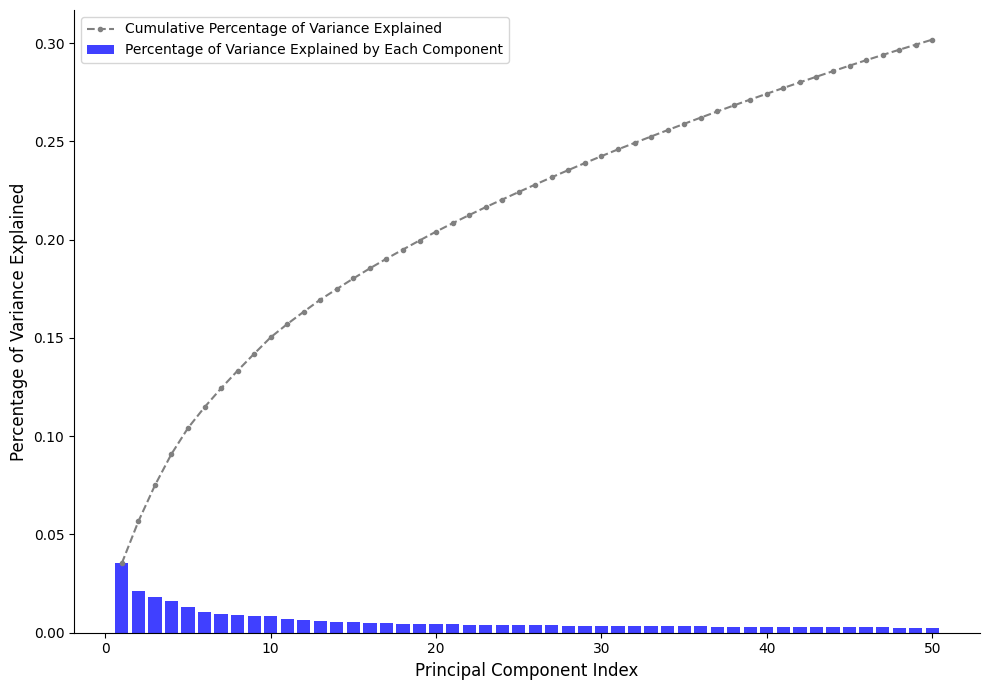

In [5]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a plot of explained variance
plt.figure(figsize=(10, 7))
plt.bar(range(1, 51), explained_variance_ratio, alpha=0.75, align='center', label='Percentage of Variance Explained by Each Component', color='blue')
plt.plot(range(1, 51), cumulative_explained_variance, marker='o', markersize=3, linestyle='--', color='grey', label='Cumulative Percentage of Variance Explained')
plt.ylabel('Percentage of Variance Explained', fontsize=12)
plt.xlabel('Principal Component Index', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save the figure
plt.savefig('./figures/PCA_Explained_Variance.png')
plt.show()

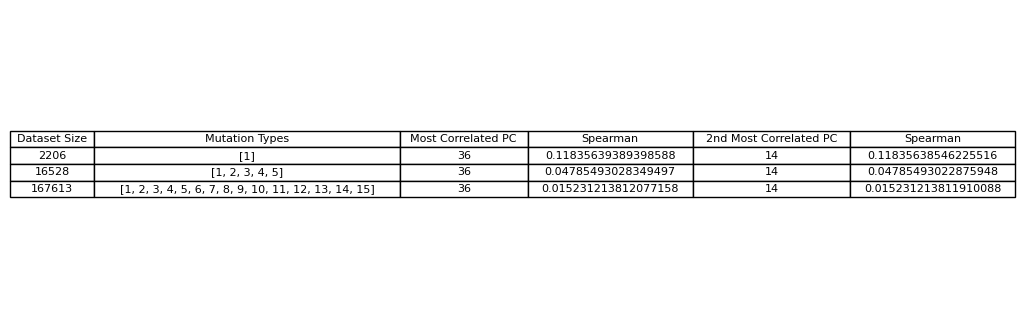

In [6]:
def process_data(df):
    # One-hot encode and flatten the data
    one_hot_encoded = one_hot_encode_msa(df, aa2ind, slen)
    nsamples, nx, ny = one_hot_encoded.shape
    flattened = one_hot_encoded.reshape((nsamples, nx * ny))

    # Transform using the existing PCA model
    principal_components = pca.transform(flattened)
    actual_scores = df['log_mean'].tolist()  # Replace 'log_mean' with the actual column name for scores

    # Find the top two best correlating principal components
    correlations = [(i, spearmanr(actual_scores, principal_components[:, i])[0]) for i in range(50)]
    top_two = sorted(correlations, key=lambda x: x[1], reverse=True)[:2]

    return len(df), list(df['MutationCount'].unique()), top_two[0][0]+1, top_two[0][1], top_two[1][0]+1, top_two[1][1]

# Apply the process to each dataset
results = []
results.append(process_data(df_DMS_single_mutants))
results.append(process_data(df_DMS_mutants_1_to_5))
results.append(process_data(df_DMS_mutants_1_to_15))

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Dataset Size', 'Mutation Types', 'Most Correlated PC', 'Spearman', '2nd Most Correlated PC', 'Spearman'])

# Create a figure and axis to display the table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, rowLabels=None, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(results_df.columns))))  # Adjust the column width

# Save the figure
plt.savefig('./figures/PCA_Datasets_Summary.png')
plt.show()

In [83]:
# The PCA component contributions
loadings = pca.components_

# Number of amino acids (including the gap '-')
num_amino_acids = len(AAs)  # Update if different

# Get the loadings for specific principal components
loadings_PC36 = loadings[35, :]
loadings_PC14 = loadings[13, :]
loadings_PC1 = loadings[0, :]

# Find the top contributing features (sequence positions) for each PC
top_features_PC36 = np.argsort(np.abs(loadings_PC36))[-10:]// num_amino_acids + 1
top_features_PC14 = np.argsort(np.abs(loadings_PC14))[-10:]// num_amino_acids + 1
top_features_PC1 = np.argsort(np.abs(loadings_PC1))[-10:]// num_amino_acids + 1

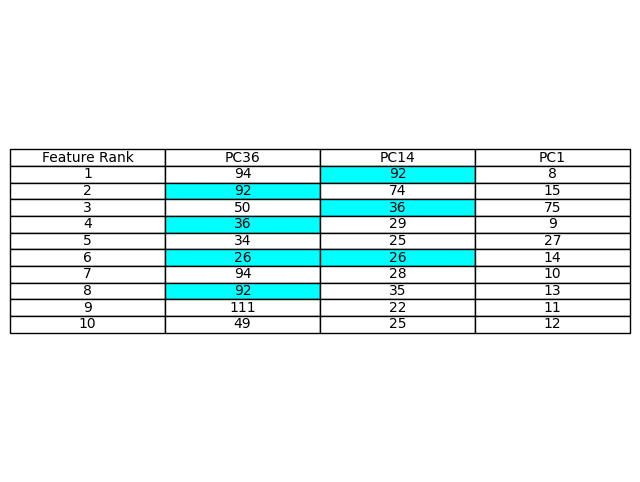

In [94]:
# Create a DataFrame for the results with a "Feature Rank" column
df_top_features = pd.DataFrame({
    'Feature Rank': range(1, 11),  # Feature rank column
    'PC36': top_features_PC36,  # Reverse to show highest first
    'PC14': top_features_PC14,
    'PC1': top_features_PC1
})

# Plot the DataFrame
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size as needed
ax.axis('off')  # Hide axes
cell_colors = df_top_features.apply(lambda x: ['cyan' if (val in df_top_features['PC14'].values and val in df_top_features['PC36'].values) else 'white' for val in x], axis=1).values
the_table = ax.table(cellText=df_top_features.values, colLabels=df_top_features.columns, loc='center', cellLoc='center', cellColours=cell_colors)
plt.savefig('PC36_PC14_Feature_Contribution.png')

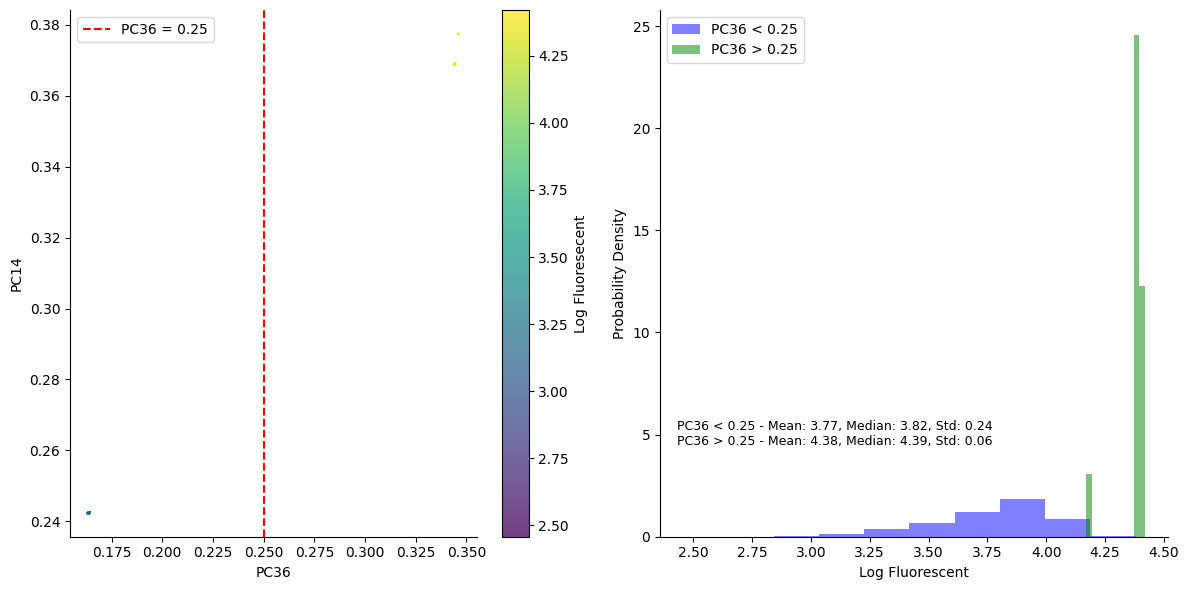

In [7]:
# Project df_DMS onto top 50 PC's
one_hot_encoded = one_hot_encode_msa(df_DMS, aa2ind, slen)
nsamples, nx, ny = one_hot_encoded.shape
flattened = one_hot_encoded.reshape((nsamples, nx * ny))
principal_components_dms = pca.transform(flattened)
actual_scores = df_DMS['log_mean'].tolist()  # Replace 'log_mean' with the actual column name for scores

# threshold based on PC14 vs. PC36 plot
threshold = 0.25

# Cluster assignment based on the threshold
cluster_1_indices = principal_components_dms[:, 35] < threshold
cluster_2_indices = principal_components_dms[:, 35] >= threshold

# Calculate the average actual score for each cluster
average_score_cluster_1 = np.mean(np.array(actual_scores)[cluster_1_indices])
average_score_cluster_2 = np.mean(np.array(actual_scores)[cluster_2_indices])
median_score_cluster_1 = np.median(np.array(actual_scores)[cluster_1_indices])
median_score_cluster_2 = np.median(np.array(actual_scores)[cluster_2_indices])
std_score_cluster_1 = np.std(np.array(actual_scores)[cluster_1_indices])
std_score_cluster_2 = np.std(np.array(actual_scores)[cluster_2_indices])

# Set up a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# PC14 vs. PC36 with threshold
scatter = axs[0].scatter(principal_components_dms[:, 35], principal_components_dms[:, 13], c=actual_scores, cmap='viridis', s=2, alpha=0.75)
axs[0].axvline(x=threshold, color='red', linestyle='--', label='PC36 = 0.25')
axs[0].set_xlabel('PC36')
axs[0].set_ylabel('PC14')
axs[0].legend()
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
fig.colorbar(scatter, ax=axs[0], label='Log Fluoresecent')

# Combined Histogram for Clusters 1 and 2
scores_cluster_1 = np.array(actual_scores)[cluster_1_indices]
scores_cluster_2 = np.array(actual_scores)[cluster_2_indices]
axs[1].hist(scores_cluster_1, color='blue', alpha=0.5, label='PC36 < 0.25', density=True)
axs[1].hist(scores_cluster_2, color='green', alpha=0.5, label='PC36 > 0.25', density=True)
axs[1].set_xlabel('Log Fluorescent')
axs[1].set_ylabel('Probability Density')
axs[1].legend()
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
stats_text = (f"PC36 < 0.25 - Mean: {average_score_cluster_1:.2f}, Median: {median_score_cluster_1:.2f}, Std: {std_score_cluster_1:.2f}\n"
              f"PC36 > 0.25 - Mean: {average_score_cluster_2:.2f}, Median: {median_score_cluster_2:.2f}, Std: {std_score_cluster_2:.2f}")
fig.text(0.7, 0.25, stats_text, ha='center', fontsize=9)
plt.tight_layout()

# Save and show the figure
plt.savefig(f'./figures/PC36_PC14_LogMeanFluoresence_Histograms.png')
plt.show()

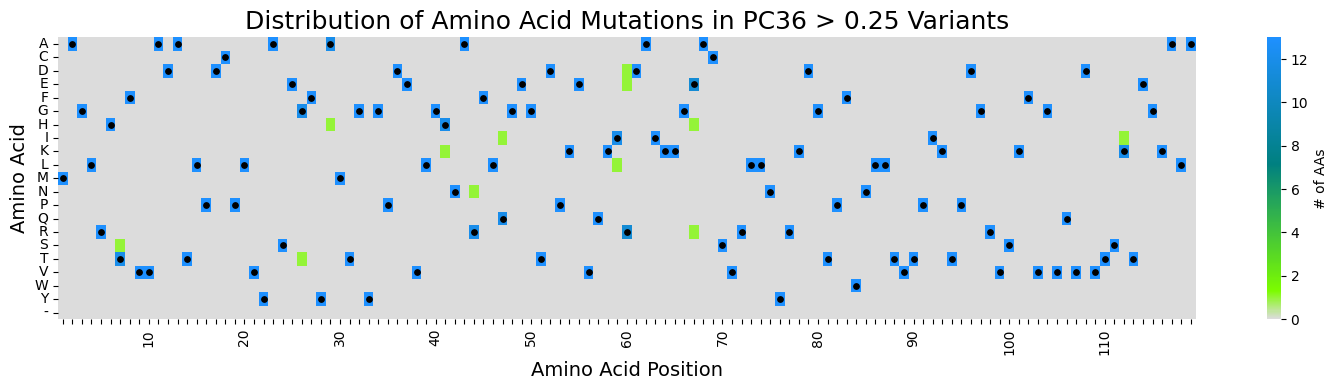

In [8]:
# Filter df_DMS to get the sequences corresponding to PC36 > 0.25
df_DMS_variants_high_PC36 = df_DMS_mutants_1_to_15[cluster_2_indices]
sequences = df_DMS_variants_high_PC36['Sequence'].tolist()

# Define the alignment and amino acids, including the gap character
alignment = list(zip(*sequences))
AAs = 'ACDEFGHIKLMNPQRSTVWY-'  # Add gap character

# Count the amino acids at each position
AA_count = np.array([[pos.count(aa) for aa in AAs] for pos in alignment])

# Create a custom colormap
colors = [(0, 'gainsboro'), (0.1, 'lawngreen'), (0.55, 'teal'), (1, 'dodgerblue')]
cmap_name = 'custom'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(15, 4))
cax = sns.heatmap(AA_count.T, cmap=custom_cmap, ax=ax, cbar_kws={'label': '# of AAs'})

# Adding dots for wild-type amino acids
for i, aa in enumerate(WT):
    if aa in AAs:
        aa_index = AAs.index(aa)
        ax.scatter(i + 0.5, aa_index + 0.5, color='black', s=15)  # Adjust the size (s) as needed

# Titles and axis labels
ax.set_title('Distribution of Amino Acid Mutations in PC36 > 0.25 Variants', fontsize=18)
ax.set_ylabel('Amino Acid', fontsize=14)
ax.set_xlabel('Amino Acid Position', fontsize=14)
ax.set_yticks(np.arange(len(AAs)) + 0.5)
ax.set_yticklabels(AAs)
xticks_positions = np.arange(0, len(WT))
xticks_labels = [str(pos+1) if (pos+1) % 10 == 0 else '' for pos in xticks_positions]
ax.set_xticks(xticks_positions + 0.5)
ax.set_xticklabels(xticks_labels)

plt.tight_layout()
plt.savefig('./figures/mutation_distribution_high_PC36.png')
plt.show()

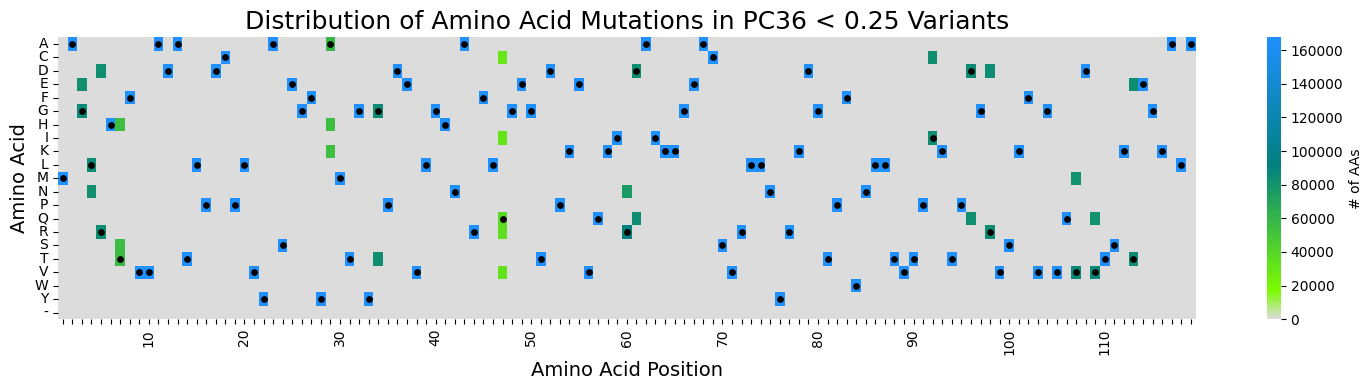

In [9]:
# Filter df_DMS to get the sequences corresponding to PC36 < 0.25
not_cluster_2_indices = ~cluster_2_indices
df_DMS_variants_not_high_PC36 = df_DMS_mutants_1_to_15[not_cluster_2_indices]
sequences = df_DMS_variants_not_high_PC36['Sequence'].tolist()  # Replace 'sequence' with the actual column name

# Define the alignment and amino acids, including the gap character
alignment = list(zip(*sequences))
AAs = 'ACDEFGHIKLMNPQRSTVWY-'  # Add gap character

# Count the amino acids at each position
AA_count = np.array([[pos.count(aa) for aa in AAs] for pos in alignment])

# Create a custom colormap
colors = [(0, 'gainsboro'), (0.1, 'lawngreen'), (0.55, 'teal'), (1, 'dodgerblue')]
cmap_name = 'custom'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(15, 4))
cax = sns.heatmap(AA_count.T, cmap=custom_cmap, ax=ax, cbar_kws={'label': '# of AAs'})

# Adding dots for wild-type amino acids
for i, aa in enumerate(WT):
    if aa in AAs:
        aa_index = AAs.index(aa)
        ax.scatter(i + 0.5, aa_index + 0.5, color='black', s=15)  # Adjust the size (s) as needed

# Titles and axis labels
ax.set_title('Distribution of Amino Acid Mutations in PC36 < 0.25 Variants', fontsize=18)
ax.set_ylabel('Amino Acid', fontsize=14)
ax.set_xlabel('Amino Acid Position', fontsize=14)
ax.set_yticks(np.arange(len(AAs)) + 0.5)
ax.set_yticklabels(AAs)
xticks_positions = np.arange(0, len(WT))
xticks_labels = [str(pos+1) if (pos+1) % 10 == 0 else '' for pos in xticks_positions]
ax.set_xticks(xticks_positions + 0.5)
ax.set_xticklabels(xticks_labels)

plt.tight_layout()
plt.savefig('./figures/mutation_distribution_low_PC36.png')
plt.show()

In [10]:
df_sorted = df_DMS_mutants_1_to_15.sort_values(by='log_mean', ascending=False)

In [11]:
df_high_PC36_sorted = df_DMS_variants_high_PC36.sort_values(by='log_mean', ascending=False)
df_high_PC36_sorted

,ID,rep1,rep2,rep3,mean,log_rep1,log_rep2,log_rep3,log_mean,Mutations,Sequence,Cluster,MutationCount
1,p.Arg60Asp,25759.5100,26659.20865,26651.35573,26356.69000,4.410938,4.425847,4.425719,4.420891,R60D,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
2,p.Thr7Ser,25817.6300,26426.82192,25983.03553,26075.83000,4.411916,4.422045,4.414690,4.416238,T7S,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
3,p.Ala29His,26195.7300,26780.29441,24982.15422,25986.06000,4.418230,4.427815,4.397630,4.414740,A29H,MAGLRHTFVVADATLPDCPLVYASEGFYHMTGYGPDEVLGHNARFL...,0,1
4,p.Gly26Thr,25376.8100,26196.45654,24196.20453,25256.49000,4.404437,4.418243,4.383747,4.402373,G26T,MAGLRHTFVVADATLPDCPLVYASETFYAMTGYGPDEVLGHNARFL...,0,1
5,p.Gln47Ile,24669.2300,26084.79570,23552.02602,24768.68000,4.392156,4.416387,4.372028,4.393903,Q47I,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
6,p.His41Lys,24605.2000,25868.75775,23830.21943,24768.06000,4.391027,4.412776,4.377128,4.393892,H41K,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,0,1
7,p.Ile59Leu,23726.3500,25389.77626,24858.15931,24658.10000,4.375231,4.404659,4.395469,4.391960,I59L,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
8,p.Lys112Ile,24819.0100,23864.22616,25262.25133,24648.50000,4.394784,4.377747,4.402472,4.391790,K112I,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
9,p.Arg60Glu,23738.6800,25755.67048,23360.45990,24284.94000,4.375457,4.410873,4.368481,4.385337,R60E,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1
10,p.Glu67Arg,22718.3200,24693.58368,25351.60347,24254.50000,4.356376,4.392584,4.404005,4.384792,E67R,MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,0,1


In [12]:
# # One-hot encode the WT sequence
# wt_encoded = one_hot_encode_msa([WT], aa2ind, slen)  # Replace 'aa2ind' and 'slen' with appropriate values
# wt_flattened = wt_encoded.reshape((1, nx * ny))

# # Project the WT sequence into the PCA space
# wt_principal_components = pca.transform(wt_flattened)

# # Attempt to reconstruct the WT sequence using the inverse transform of PCA
# wt_reconstructed = pca.inverse_transform(wt_principal_components)

# # Reshape the reconstructed sequence back to its original shape
# wt_reconstructed_reshaped = wt_reconstructed.reshape((1, nx, ny))

# def decode_sequence(encoded_seq, aa_list):
#     """
#     Decode a one-hot encoded sequence back to its amino acid sequence.
    
#     :param encoded_seq: One-hot encoded sequence (numpy array).
#     :param aa_list: List of amino acids used in the encoding.
#     :return: Decoded amino acid sequence (string).
#     """
#     decoded_seq = ''
#     for position in encoded_seq:
#         sorted_indices = np.argsort(position)[::-1]  # Get indices sorted by highest probability
#         aa_index = sorted_indices[0]
#         if aa_list[aa_index] == '-':  # Check if the highest probability is for the gap
#             aa_index = sorted_indices[1]  # Choose the second highest probability
#         decoded_seq += aa_list[aa_index]
#     return decoded_seq

# # Example usage
# aa_list = 'ACDEFGHIKLMNPQRSTVWY'  # List of amino acids (ensure this matches your encoding)
# decoded_wt_sequence = decode_sequence(wt_reconstructed_reshaped[0], AAs)
# decoded_wt_sequence

In [13]:
# def hamming_distance(s1, s2):
#         """Calculates the Hamming distance between two sequences"""
#         return sum(1 for x, y in zip(s1, s2) if x != y) # Quantify sequence similarity
# WT

In [14]:
# hd_recon = hamming_distance(decoded_wt_sequence, WT)
# print(hd_recon)

In [15]:
# # Flatten the one_hot_encoded_msa for PCA, since PCA expects 2D data (samples, features)
# nsamples, nx, ny = one_hot_encoded_msa.shape
# flattened_msa = one_hot_encoded_msa.reshape((nsamples, nx*ny))

# # Create a PCA instance and fit it to the data, keep top 2 dimensions
# pca = PCA(n_components=100, random_state=0)
# principal_components = pca.fit_transform(flattened_msa)

# # One-hot encode the WT sequence
# wt_encoded = one_hot_encode_msa([WT], aa2ind, slen)  # Replace 'aa2ind' and 'slen' with appropriate values
# wt_flattened = wt_encoded.reshape((1, nx * ny))

# # Project the WT sequence into the PCA space
# wt_principal_components = pca.transform(wt_flattened)

# # Attempt to reconstruct the WT sequence using the inverse transform of PCA
# wt_reconstructed = pca.inverse_transform(wt_principal_components)

# # Reshape the reconstructed sequence back to its original shape
# wt_reconstructed_reshaped = wt_reconstructed.reshape((1, nx, ny))

# def decode_sequence(encoded_seq, aa_list):
#     """
#     Decode a one-hot encoded sequence back to its amino acid sequence.
    
#     :param encoded_seq: One-hot encoded sequence (numpy array).
#     :param aa_list: List of amino acids used in the encoding.
#     :return: Decoded amino acid sequence (string).
#     """
#     decoded_seq = ''
#     for position in encoded_seq:
#         sorted_indices = np.argsort(position)[::-1]  # Get indices sorted by highest probability
#         aa_index = sorted_indices[0]
#         if aa_list[aa_index] == '-':  # Check if the highest probability is for the gap
#             aa_index = sorted_indices[1]  # Choose the second highest probability
#         decoded_seq += aa_list[aa_index]
#     return decoded_seq

# # Example usage
# aa_list = 'ACDEFGHIKLMNPQRSTVWY'  # List of amino acids (ensure this matches your encoding)
# decoded_wt_sequence = decode_sequence(wt_reconstructed_reshaped[0], AAs)
# decoded_wt_sequence

In [16]:
# hd_recon = hamming_distance(decoded_wt_sequence, WT)
# print(hd_recon)

In [17]:
# # Flatten the one_hot_encoded_msa for PCA, since PCA expects 2D data (samples, features)
# nsamples, nx, ny = one_hot_encoded_msa.shape
# flattened_msa = one_hot_encoded_msa.reshape((nsamples, nx*ny))

# # Create a PCA instance and fit it to the data, keep top 2 dimensions
# pca = PCA(n_components=200, random_state=0)
# principal_components = pca.fit_transform(flattened_msa)

# # One-hot encode the WT sequence
# wt_encoded = one_hot_encode_msa([WT], aa2ind, slen)  # Replace 'aa2ind' and 'slen' with appropriate values
# wt_flattened = wt_encoded.reshape((1, nx * ny))

# # Project the WT sequence into the PCA space
# wt_principal_components = pca.transform(wt_flattened)

# # Attempt to reconstruct the WT sequence using the inverse transform of PCA
# wt_reconstructed = pca.inverse_transform(wt_principal_components)

# # Reshape the reconstructed sequence back to its original shape
# wt_reconstructed_reshaped = wt_reconstructed.reshape((1, nx, ny))

# def decode_sequence(encoded_seq, aa_list):
#     """
#     Decode a one-hot encoded sequence back to its amino acid sequence.
    
#     :param encoded_seq: One-hot encoded sequence (numpy array).
#     :param aa_list: List of amino acids used in the encoding.
#     :return: Decoded amino acid sequence (string).
#     """
#     decoded_seq = ''
#     for position in encoded_seq:
#         sorted_indices = np.argsort(position)[::-1]  # Get indices sorted by highest probability
#         aa_index = sorted_indices[0]
#         if aa_list[aa_index] == '-':  # Check if the highest probability is for the gap
#             aa_index = sorted_indices[1]  # Choose the second highest probability
#         decoded_seq += aa_list[aa_index]
#     return decoded_seq

# # Example usage
# aa_list = 'ACDEFGHIKLMNPQRSTVWY'  # List of amino acids (ensure this matches your encoding)
# decoded_wt_sequence = decode_sequence(wt_reconstructed_reshaped[0], AAs)
# decoded_wt_sequence

In [18]:
# hd_recon = hamming_distance(decoded_wt_sequence, WT)
# print(hd_recon)

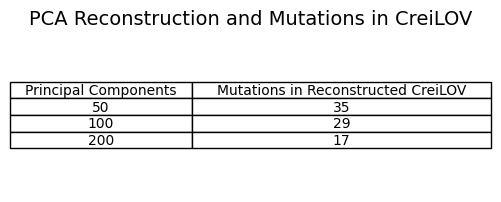

In [19]:
# Data for the table
num_principal_components = ["50", "100", "200"]
num_mutations = ["35", "29", "17"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed
ax.axis('off')  # Hide the axes

# Create the table and add it to the plot
table_data = list(zip(num_principal_components, num_mutations))
column_labels = ["Principal Components", "Mutations in Reconstructed CreiLOV"]
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc = 'center', loc='center')

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(column_labels))))  # Adjust the column width

plt.title('PCA Reconstruction and Mutations in CreiLOV', fontsize=14, pad=10)

# Save the figure as a PNG file
plt.savefig('./figures/PCA_Reconstructed_CreiLOV_Mutations_Table.png')
plt.show()


In [20]:
# load generative models
checkpoint_path = "./Best_ConvVAE.ckpt"
vae_model = load_vae_model(checkpoint_path)

In [21]:
# # Initialize your custom dataset with df_DMS
# dataset = SeqDataset(df_DMS)  # Make sure df_DMS is in the correct format for SeqDataset

# # Define a smaller batch size
# batch_size = 32  # Adjust this based on your system's memory capacity

# # Initialize a DataLoader with the created dataset
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# # Prepare to store latent representations and decoded sequences
# latent_representations = []
# decoded_sequences = []

# # Iterate over the DataLoader and pass each batch through the VAE
# for sequences in dataloader:
#     encoded_batch, decoded_batch = Using_VAE(vae_model, sequences)
#     latent_representations.append(encoded_batch)  # Move to CPU to save GPU memory
#     decoded_sequences.append(decoded_batch)


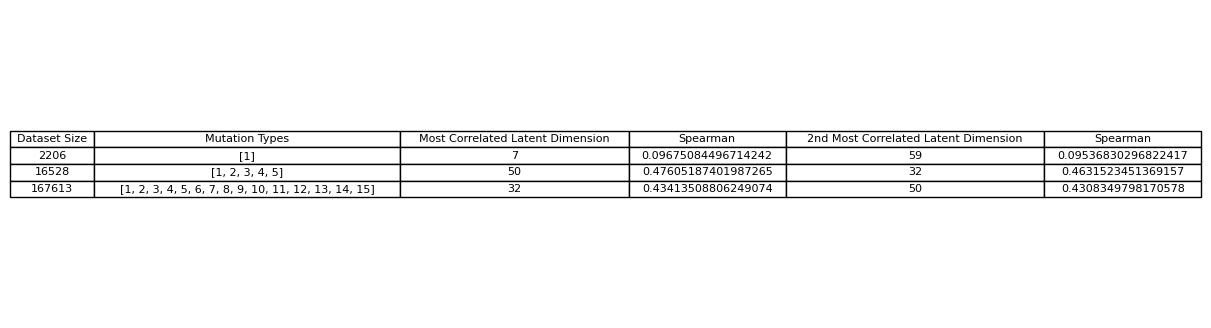

In [22]:
# Correlate latent dimensions with log mean fluo

# Filter the dataframe to only include mutants with 1 to 4 mutations
df_DMS_single_mutants = df_DMS[(df_DMS['MutationCount'] == 1)]
df_DMS_mutants_1_to_5 = df_DMS[(df_DMS['MutationCount'] <= 5)]
df_DMS_mutants_1_to_15 = df_DMS

def process_data_with_vae(vae_model, df):
    """
    Computes Spearman correlation for each latent dimension with actual scores.
    Args:
        vae_model: Trained VAE model.
        df (pandas.DataFrame): DataFrame containing sequences and 'log_mean' scores.
    Returns:
        Dataset size, mutation types, indices and Spearman correlations of the top two correlated latent dimensions.
    """
    # Generate latent representations for the dataset
    dataset = SeqDataset(df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    latent_representations = []
    for sequences in dataloader:
        with torch.no_grad():
            encoded, _ = Using_VAE(vae_model, sequences)
            latent_representations.append(encoded)
    
    latent_representations = torch.cat(latent_representations, dim=0)
    actual_scores = df['log_mean'].tolist()

    # Calculate Spearman correlations
    correlations = [(i, spearmanr(actual_scores, latent_representations[:, i].numpy())[0]) for i in range(latent_representations.shape[1])]
    top_two = sorted(correlations, key=lambda x: x[1], reverse=True)[:2]

    return len(df), list(df['MutationCount'].unique()), top_two[0][0]+1, top_two[0][1], top_two[1][0]+1, top_two[1][1]

# Apply the process to each dataset
results = []
results.append(process_data_with_vae(vae_model, df_DMS_single_mutants))
results.append(process_data_with_vae(vae_model, df_DMS_mutants_1_to_5))
results.append(process_data_with_vae(vae_model, df_DMS_mutants_1_to_15))

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Dataset Size', 'Mutation Types', 'Most Correlated Latent Dimension', 'Spearman', '2nd Most Correlated Latent Dimension', 'Spearman'])

# Create a figure and axis to display the table
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, rowLabels=None, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(results_df.columns))))  # Adjust the column width

# Save the figure
plt.savefig('./figures/VAE_Datasets_Summary.png')
plt.show()


In [23]:
def extract_latent_dimension(vae_model, df, latent_dim_index):
    """
    Extracts a specific latent dimension and actual scores from the dataset.
    Args:
        vae_model: Trained VAE model.
        df (pandas.DataFrame): DataFrame containing sequences and 'log_mean' scores.
        latent_dim_index (int): Index of the latent dimension to extract.
    Returns:
        Latent dimension values and actual scores.
    """
    dataset = SeqDataset(df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    latent_values = []
    for sequences in dataloader:
        with torch.no_grad():
            encoded, _ = Using_VAE(vae_model, sequences)
            latent_values.extend(encoded[:, latent_dim_index].cpu().numpy())

    actual_scores = df['log_mean'].tolist()
    return latent_values, actual_scores

# Extract the 50th latent dimension values and actual scores for df_DMS_mutants_1_to_5
latent_dim_values, actual_scores = extract_latent_dimension(vae_model, df_DMS_mutants_1_to_5, 49)  # 49 for 50th dimension (0-indexed)

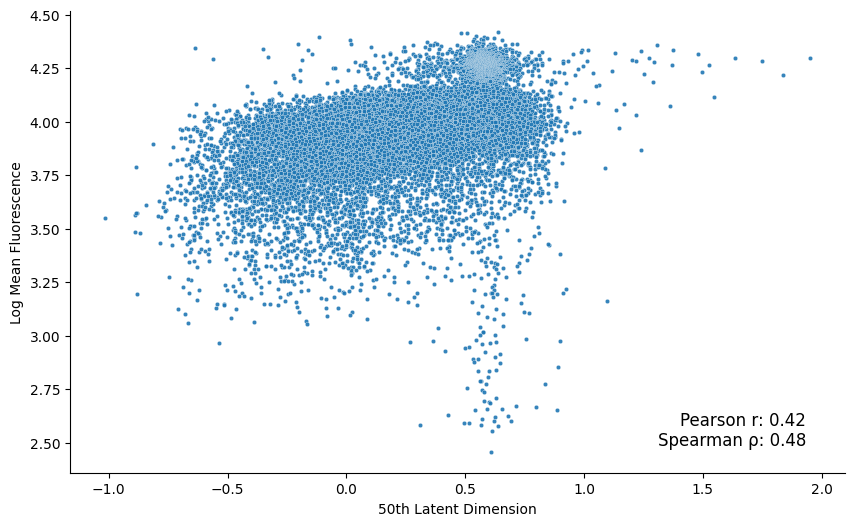

In [24]:
# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(latent_dim_values, actual_scores)
spearman_corr, _ = spearmanr(latent_dim_values, actual_scores)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_dim_values, y=actual_scores, alpha=0.9, s=10)
plt.xlabel('50th Latent Dimension')
plt.ylabel('Log Mean Fluorescence')
sns.despine()
plt.text(0.95, 0.05, f'Pearson r: {pearson_corr:.2f}\nSpearman ρ: {spearman_corr:.2f}',
         fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

plt.savefig('./figures/50_latend_dim_vs_log_mean_fluorescence.png')

In [25]:
# Correlate cross-entropy with log mean fluorescence
def process_data_with_vae(vae_model, df):
    """
    Computes cross-entropy loss for each sequence and calculates Spearman correlation with actual scores.
    Args:
        vae_model: Trained VAE model.
        df (pandas.DataFrame): DataFrame containing sequences and 'log_mean' scores.
    Returns:
        Spearman correlation between cross-entropy loss and actual scores.
    """
    # Prepare sequences for VAE
    dataset = SeqDataset(df)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum') # find cross entropy for each protein
    losses = []
    actual_scores = df['log_mean'].tolist()

    for sequences in dataloader:
        with torch.no_grad():
            encoded, decoded = Using_VAE(vae_model, sequences)
            # Calculate loss for each sequence
            loss = -1*cross_entropy_loss(decoded, sequences)
            losses.append(loss.item())  # Store individual losses

    # Calculate Spearman correlation
    spearmanr_corr, _ = spearmanr(losses, actual_scores)
    pearson_corr, _ = pearsonr(losses, actual_scores)
    return spearmanr_corr, pearson_corr, losses, actual_scores

In [26]:
spearman_correlation, pearson_correlation, losses, actual_scores = process_data_with_vae(vae_model, df_DMS)
print(f"Spearman Correlation: {spearman_correlation}")
print(f"Pearson Correlation: {pearson_correlation}")

Spearman Correlation: 0.2868113057253594
Pearson Correlation: 0.2909034446403878


In [27]:
spearman_correlation_2, pearson_correlation_2, losses_2, actual_scores_2 = process_data_with_vae(vae_model, df_DMS_mutants_1_to_5)
print(f"Spearman Correlation: {spearman_correlation_2}")
print(f"Pearson Correlation: {pearson_correlation_2}")

Spearman Correlation: 0.27177202124212657
Pearson Correlation: 0.19731306496730786


In [28]:
spearman_correlation_3, pearson_correlation_3, losses_3, actual_scores_3 = process_data_with_vae(vae_model, df_DMS_single_mutants)
print(f"Spearman Correlation: {spearman_correlation_3}")
print(f"Pearson Correlation: {pearson_correlation_3}")

Spearman Correlation: 0.3141171326125618
Pearson Correlation: 0.2550311570955688


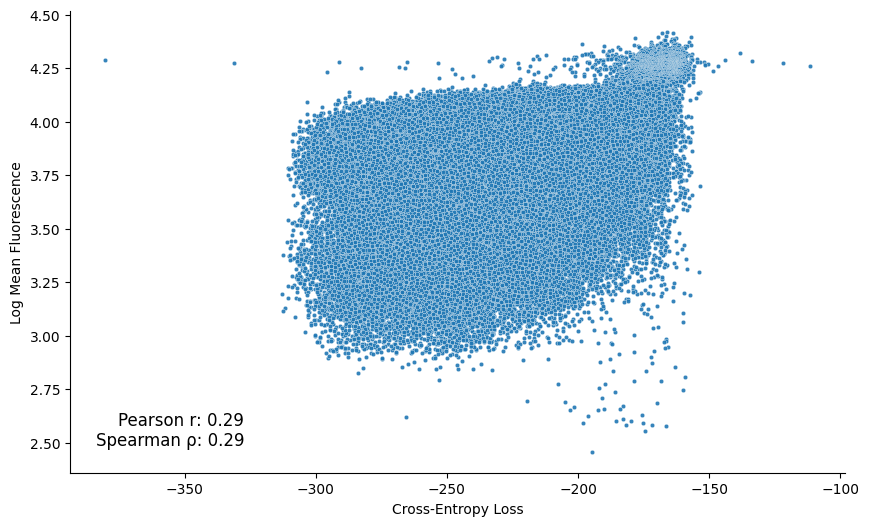

In [29]:
# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(losses, actual_scores)
spearman_corr, _ = spearmanr(losses, actual_scores)

# Plotting the losses and actual scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=losses, y=actual_scores, alpha=0.9, s=10)  # Adjust alpha and size as needed
plt.xlabel('Cross-Entropy Loss')
plt.ylabel('Log Mean Fluorescence')
sns.despine()
plt.text(0.225, 0.05, f'Pearson r: {pearson_corr:.2f}\nSpearman ρ: {spearman_corr:.2f}',
         fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

plt.savefig('./figures/cross_entropy_vs_log_mean_fluorescence.png')

In [30]:
# Reconstructing CreiLOV

# Define amino acid dictionary for tokenization, define WT for length of context window (slen)
AAs = 'ACDEFGHIKLMNPQRSTVWY-' # setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
WT = "MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
Best_Mutant = "MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
Worst_Mutant = "MAGLRHTFVVADATLPDCPWVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA"
slen = len(WT)
aa2ind = OrderedDict([(aa, i) for i, aa in enumerate(AAs)])

# Put CreiLOV in dataframe
df = pd.DataFrame({'Sequence': [WT, Best_Mutant]})
dataset = SeqDataset(df)
batch_size = len(df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Get the number of batches and the batch size
num_batches = len(dataloader)
batch_size = dataloader.batch_size
sequence_length = len(WT)  # replace with actual length if WT is not provided

# Initialize a tensor to store batch tensors
sequences_batch = torch.zeros((num_batches * batch_size, sequence_length), dtype=torch.long)

# Iterate over the batches and store the sequence tensors
for i, sequences in enumerate(dataloader):
    start_index = i * batch_size
    end_index = start_index + sequences.size(0)
    sequences_batch[start_index:end_index] = sequences

# print(sequences_batch[0])

### Example: Send sequence into VAE to find latent representations
CreiLOV_representations, decoded_CreiLOVs = Using_VAE(vae_model,sequences_batch)
# print(CreiLOV_representations.type()) # Check type
# print(CreiLOV_representations.size()) # Check size
# print(CreiLOV_representations)
# decoded_CreiLOVs

# Identify the max values for each amino acid positions
# decoded_CreiLOV_nar = torch.narrow(decoded_CreiLOVs, 1, 0, 20)
# print(decoded_CreiLOV_nar.size())
_, max_indices = torch.max(decoded_CreiLOVs[:,:20,:], dim=1)  # Take max along the last dimension

# Step 2: Create a reverse mapping manually based on the AAs string
ind2aa = {i: aa for i, aa in enumerate(AAs)}

# Convert the tensor to a list of indices
max_indices_list = max_indices.tolist()

# Initialize an empty list to hold the decoded sequences
decoded_sequences = []

# Iterate over each batch
for batch in max_indices_list:
    decoded_sequence = ''.join([ind2aa[idx] for idx in batch])
    decoded_sequences.append(decoded_sequence)

print(WT)
print(decoded_sequences[0])
# print(Best_Mutant)
# print(decoded_sequences[1])

# Mutations in decoded CreiLOV and best mutant
aa_mut0, dist0 = hamming_distance(WT, decoded_sequences[0])
print(aa_mut0)
print(dist0)
# aa_mut1, dist1 = hamming_distance(Best_Mutant, decoded_sequences[1])
# print(aa_mut1)
# print(dist1)


MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA
DKGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNCRFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGALLL
6
[{'pos': 1, 'orig_aa': 'M', 'mut_aa': 'D'}, {'pos': 2, 'orig_aa': 'A', 'mut_aa': 'K'}, {'pos': 43, 'orig_aa': 'A', 'mut_aa': 'C'}, {'pos': 116, 'orig_aa': 'K', 'mut_aa': 'A'}, {'pos': 117, 'orig_aa': 'A', 'mut_aa': 'L'}, {'pos': 119, 'orig_aa': 'A', 'mut_aa': 'L'}]
